In [1]:
import pickle
import numpy as np
import pandas as pd

from helper import *
from loading_models import *
from sklearn.linear_model import Ridge # for the blending
from surprise.model_selection import train_test_split
from surprise_models import *
from simple_models import *

# for visualization
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
generation_models = False
generation_final_models = False

In [3]:
seed = 1

In [4]:
data_name = "data/47b05e70-6076-44e8-96da-2530dc2187de_data_train.csv"
test_name = "data/sampleSubmission.csv"

## Data Exploration

Nbr Rate Per User
min: 3
max: 522
mean: 117.6952
Nbr Rate Per Film
min: 8
max: 4590
mean: 1176.952
(1000, 1)
<class 'pandas.core.frame.DataFrame'>


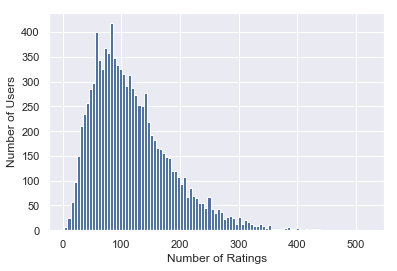

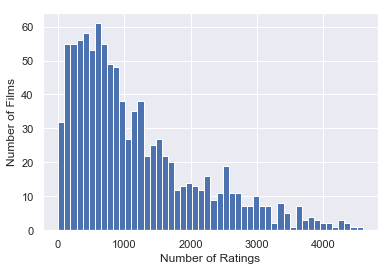

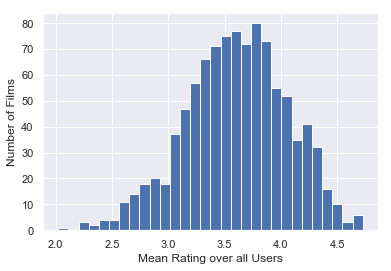

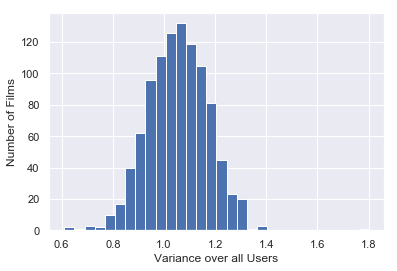

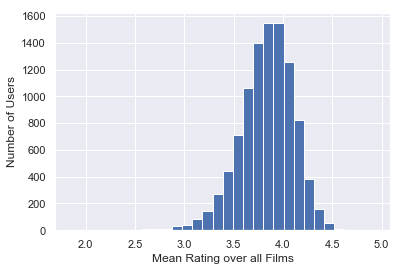

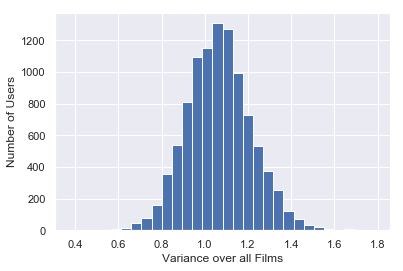

In [5]:
# load the trainset
sp_ratings, pd_ratings = load_data_sparse(data_name, True)

# convert it into surprise
spr_data = pandas_to_surprise(pd_ratings)

## Build prediction for training set

#### Put the data in the correct format

In [6]:
if generation_models:
    # file where you want to save all the following models
    PATHSAVE = 'models/' 

    # split into train + test
    trainset, testset = train_test_split(spr_data, test_size=.1, random_state=988)

    # save train + test set
    pickle.dump(trainset, open(PATHSAVE + 'trainset.pkl', 'wb'))
    pickle.dump(testset, open(PATHSAVE + 'testset.pkl', 'wb'))

    # get label
    _,_,labels = get_testset_indices(testset)

    # save labels
    pickle.dump(labels, open(PATHSAVE + 'labels.pkl', 'wb'))

    # run the models
    learning(trainset, testset, labels, PATHSAVE)

WARNING : the parameters for the ALS and SGD are hard-coded inside this function

## Compute final prediction

In [7]:
if generation_final_models:
    # file where you want to save all the following models
    PATHSAVE = 'final_models/' 
    
    _, pd_pred = load_data_sparse(test_name, False)
    
    # define train + test sets
    trainset = spr_data.build_full_trainset()
    testset = pandas_to_surprise(pd_pred, pred=True)
    
    # run the models
    learning(trainset, testset, labels, PATHSAVE)

## Load the models

In [8]:
class Model:
    name = ''
    rmse = 0.0
    model = ''
    final_model = ''

In [9]:
labels = pickle.load(open('models/labels.pkl', 'rb'))
models = loadModels()

#### Compute RMSE for each model 

The ranking of the models will be done from the lower RMSE to the higher

In [10]:
for m in models:
    m.rmse = calculate_rmse(labels, m.model)

In [11]:
import operator
sorted_models = sorted(models, key=operator.attrgetter('rmse'))

In [12]:
for m in sorted_models:
    print('Model %s : %s' % (m.name,m.rmse))

Model als : 0.9842761153117054
Model bsknn : 0.9856890199729544
Model so : 0.9969080076726844
Model svdpp : 0.9974433490996525
Model svd : 0.997766335033669
Model basicknn : 1.0218854894245444
Model sgd : 1.0228761455871391
Model usermean : 1.0277625350651283
Model itemmean : 1.0933093510076437
Model usermedian : 1.0971948682814474
Model globalmean : 1.117181294724137
Model globalmedian : 1.1257663090048857
Model itemmedian : 1.1482061792157034
Model baseline : 1.2242112307678474


## Find the number of model to put in blending

#### Build the prediction matrix

In [13]:
prediction = []

for m_id, m in enumerate(sorted_models): # 14
    if m_id == 0:
        prediction = m.model
    else:
        prediction = np.vstack((prediction,m.model))
        
prediction = np.transpose(prediction)

#### Split the data for cross-validation

In [14]:
# split data in k fold
k_fold = 4
labels = np.array(labels)
k_indices = build_k_indices(labels, k_fold)

[44828  5044 56809 ... 20463 18638 35683]


#### Compute the RMSE for different number of model(s)

In [15]:
rmse_evolution = []

for k in range(k_fold):
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    x_te = prediction[te_indice]
    y_te = labels[te_indice]

    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    x_tr = prediction[tr_indice]
    y_tr = labels[tr_indice]
    
    tmp_rmse_test_evolution = []
    tmp_rmse_train_evolution = []
    
    for i in range(len(sorted_models)):
        # Blending
        linreg = Ridge(alpha=0.1, fit_intercept=False, random_state=seed)
        linreg.fit(x_tr[:,0:i+1], y_tr)
        #print(linreg.coef_) # print weight for each model

        rmse_tr = calculate_rmse(y_tr, x_tr[:,0:i+1].dot(linreg.coef_))
        rmse_te = calculate_rmse(y_te, x_te[:,0:i+1].dot(linreg.coef_))
        #print('With %s model(s) : %s' % (i+1,rmse))
        
        rmse_evolution.append([i+1,rmse_tr,'train error'])
        rmse_evolution.append([i+1,rmse_te,'test error'])
        
rmse_evolution = pd.DataFrame(rmse_evolution)
rmse_evolution.columns = ['Number of model(s)','RMSE','Label'] 

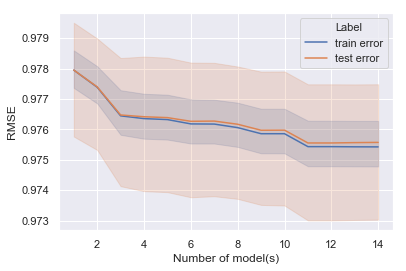

In [16]:
ax = sns.lineplot(x="Number of model(s)", y="RMSE", hue="Label", data=rmse_evolution)
plt.savefig("NbrModels.png", bbox_inches='tight')

In [17]:
best_nbrmodel = 11

#### Compute the RMSE for different degree of feature expansion

In [18]:
# reshape the prediction matrix to include only the models 1 to best_nbrmodel, in this case 11
prediction = []
k_models = sorted_models[0:best_nbrmodel]

for m_id, m in enumerate(k_models): # 14
    if m_id == 0:
        prediction = m.model
    else:
        prediction = np.vstack((prediction,m.model))

prediction = np.transpose(prediction)

In [19]:
rmse_evolution = []

for k in range(k_fold):
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    x_te = prediction[te_indice]
    y_te = labels[te_indice]

    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    x_tr = prediction[tr_indice]
    y_tr = labels[tr_indice]
    
    tmp_rmse_test_evolution = []
    tmp_rmse_train_evolution = []
    
    for i in range(1,4):
        train = polynomial_features(x_tr,i) # polynomial_features(prediction,2)
        # Blending
        linreg = Ridge(alpha=0.1, fit_intercept=False, random_state=seed)
        linreg.fit(train, y_tr)
        #print(linreg.coef_) # print weight for each model

        test = polynomial_features(x_te,i)
        rmse_tr = calculate_rmse(y_tr, train.dot(linreg.coef_))
        rmse_te = calculate_rmse(y_te, test.dot(linreg.coef_))
        #print('With %s model(s) : %s' % (i+1,rmse))
        
        rmse_evolution.append([i,rmse_tr,'train error'])
        rmse_evolution.append([i,rmse_te,'test error'])
    
rmse_evolution = pd.DataFrame(rmse_evolution) 
rmse_evolution.columns = ['Degree','RMSE','Label'] 

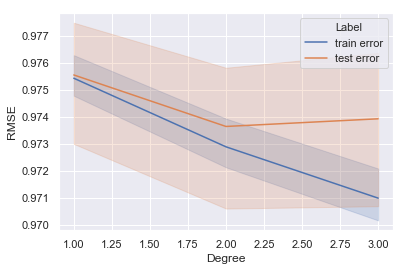

In [20]:
ax = sns.lineplot(x="Degree", y="RMSE", hue="Label", data=rmse_evolution)
plt.savefig("Degree.png", bbox_inches='tight')

In [21]:
best_degree = 2

In [22]:
print(np.mean(rmse_evolution[rmse_evolution['Degree'] == 2]))
print(np.std(rmse_evolution[rmse_evolution['Degree'] == 2]))

Degree    2.000000
RMSE      0.973271
dtype: float64
Degree    0.000000
RMSE      0.001997
dtype: float64


## Final Blending

Once the optimal number of model, as well as the optimal degree of expansion are found. We have to run the final blending using those parameters.

Build matrices:
- the prediciton matrix : used for the final weight computation. 
- the final prediction matrix : used for the submission

In [23]:
prediction_final = []
prediction = []

k_models = sorted_models[0:best_nbrmodel]

for m_id, m in enumerate(k_models): # 14
    if m_id == 0:
        prediction = m.model
        prediction_final = m.final_model
    else:
        prediction = np.vstack((prediction,m.model))
        prediction_final = np.vstack((prediction_final,m.final_model))

prediction = np.transpose(prediction)
prediction_final = np.transpose(prediction_final)

In [24]:
print(prediction.shape)
print(prediction_final.shape)

(117696, 11)
(1176952, 11)


Feature expansion on those matrices

In [25]:
prediction = polynomial_features(prediction,best_degree)
prediction_final = polynomial_features(prediction_final,best_degree)

Final blending to find the weight

In [26]:
linreg = Ridge(alpha=0.01, fit_intercept=False, random_state=seed)
linreg.fit(prediction, labels)
print(linreg.coef_) # print weight for each model

[ 8.06308989e-02  1.98237596e-01 -2.84423669e-02  7.80167560e-01
  1.12747240e-01 -3.21769940e-01 -1.13582958e-02 -1.10409045e-02
 -6.60549992e-01 -6.09325434e-01  7.10629471e-03  3.10926946e-01
 -2.24952624e-01  3.31260326e-01  1.11632045e+00 -1.94375031e-01
 -3.07528648e-02  2.26535173e-01 -4.48470549e-01 -6.77081556e-01
 -4.71739957e-01  3.78630582e-02  7.64551107e-01 -1.52322468e-01
  9.35204598e-02 -9.64346036e-02 -6.95602620e-02  6.40264565e-02
 -2.15072235e-01  3.97715909e-01 -2.43148996e-02  8.48240336e-03
 -1.09696026e-01  1.41559419e+00  1.85923658e-02 -3.50993893e-01
 -1.72134714e-01  1.49261805e-01 -3.32983759e+00 -3.40788403e+00
 -1.49059425e-01  3.00898741e+00  2.49226757e-01 -8.71773349e-01
 -5.59062610e-02  6.77396341e-01 -3.64244152e-01 -1.67498899e-01
  1.22171261e-01  4.34828217e-01 -4.42367813e-02 -5.18909628e-02
 -3.12125446e-01  1.26702122e+00  1.76910787e+00  1.34562281e-02
 -1.24099814e+00  5.26839700e-02  2.53133790e-01 -2.75214720e-01
 -1.07672577e-02 -1.40673

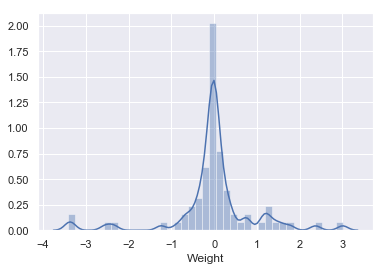

In [27]:
sns.distplot(linreg.coef_, axlabel="Weight")
plt.savefig("Weights.png", bbox_inches='tight')

In [28]:
print(np.min(linreg.coef_))
print(np.max(linreg.coef_))

-3.4078840288441175
3.0089874109011125


In [29]:
np.mean(linreg.coef_)

0.002144910582802887

Training RMSE

In [30]:
rmse = calculate_rmse(labels, prediction.dot(linreg.coef_))
rmse

0.9729853705145273

#### Final prediction

In [31]:
final_result = []

for m_id in range(prediction_final.shape[1]):
    if m_id == 0:
        final_result = linreg.coef_[m_id] * prediction_final[:,m_id]
    else:
        final_result = final_result + linreg.coef_[m_id] * prediction_final[:,m_id]

#### Create Submission

In [32]:
create_submission_from_prediction(final_result, 'final_submission.csv')